In [476]:
from pathlib import Path
import numpy as np 
from PIL import Image

import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import seaborn as sns

import utils
sns.set(style="whitegrid")

In [696]:
CLASSES = ['Healthy', 'OCDegen']
input_stages = {'0': 'training', '1': 'validation_nodiag', '2': 'validation_noxai'}
BASEPATH = Path('/Users/djohnson/sciebo/1. Research/1. HCXAI/1. Projects/evalxai_studies/')

In [763]:
high_stakes_pth = BASEPATH / 'example_validation_study'
low_stakes_pth = BASEPATH / 'example_validation_study_ls'

stage1_pth = 'validation_nodiag/results'
stage2_pth = 'validation_noxaiu/results'

In [ ]:
filters = ['123451234512345123451234', '660ff395894d843a4c0c025b', '678b4ff772b1e5c63e30b608']

def get_id(res_file: Path):
    return res_file.stem.split('_')[-1]

def include_id(df):
    include = df.id not in filters
    return include

In [697]:
# ids from final stage to ensure completion
ids_hs = [get_id(f) for f in (high_stakes_pth / stage2_pth).rglob('*.csv')]
ids_ls = [get_id(f) for f in (low_stakes_pth / stage2_pth).rglob('*.csv')]

print(len(ids1), len(ids2))

30 30


In [698]:
dfs_0 = {id: pd.read_csv(BASEPATH / input_stages['0'] / 'results' / f'results_{input_stages["0"]}_{id}.csv') for id in ids2}
dfs_1 = {id: pd.read_csv(BASEPATH / input_stages['1'] / 'results' / f'results_{input_stages["1"]}_{id}.csv') for id in ids2}
dfs_2 = {id: pd.read_csv(BASEPATH / input_stages['2'] / 'results' / f'results_{input_stages["2"]}_{id}.csv') for id in ids2}

In [699]:
len(dfs_0), len(dfs_1), len(dfs_2)

(30, 30, 30)

In [700]:
def get_results(df, stage):
    
    acc = (df['true'] == df['select']).astype(int).mean()
    dec_time = (df['updated'] - df['accessed_updated']).mean()

    # stage one only has an accuracy value sine there is no AI
    if stage == '1':
       return acc, dec_time
    
    agree_cond = df['pred'] == df['select']
    disagree_cond = df['pred'] != df['select']

    correct_preds = (df['pred'] == df['true'])
    incorrect_preds = (df['pred'] != df['true'])  

    # overreliance
    or_cond = agree_cond & incorrect_preds
    overreliance = (or_cond).astype(int).sum() / incorrect_preds.astype(int).sum()

    ur_cond = disagree_cond & correct_preds
    underreliance = (ur_cond).astype(int).sum() / correct_preds.astype(int).sum()

    # agreement
    reliance = (agree_cond).astype(int).sum() / len(df)
    
    # disagreement
    disagree = (disagree_cond).astype(int).sum() / len(df)

    # healthy distrust (prev. approp. reliance)
    hdt_cond = disagree_cond & incorrect_preds
    h_distrust = (hdt_cond).astype(int).sum() / (incorrect_preds).astype(int).sum()

    # health trust
    ht_cond = agree_cond & correct_preds
    h_trust = (ht_cond).astype(int).sum() / (correct_preds).astype(int).sum()

    return acc, reliance, overreliance, underreliance, disagree, h_distrust, h_trust, dec_time


In [701]:
# columns = ['id', 'accuracy1', 'accuracy2', 'reliance2', 'overreliance2', 'disagreement2', 'appropriate_reliance2']
dfs = []
for (id0, df0), (id1, df1), (id2, df2) in zip(dfs_0.items(), dfs_1.items(), dfs_2.items()):
    assert id1 == id2 and id0 == id1, 'IDs do not match'

    acc0, dec_time0 = get_results(df0, stage='1')

    acc1, dec_time1 = get_results(df1, stage='1')
    acc2, reliance2, overreliance2, underreliance2, disagree2, h_distrust2, h_trust2, dec_time2 = get_results(df2, stage='2')

    results = dict(
        id = id1,
        accuracy0 = acc0,
        accuracy1 = acc1, 
        accuracy2 = acc2, 
        reliance2 = reliance2,
        overreliance2 = overreliance2,
        underreliance2 = underreliance2,
        healthy_distrust2 = h_distrust2,
        healthy_trust2 = h_trust2,
        dec_time0 = dec_time0,
        dec_time1 = dec_time1,
        dec_time2 = dec_time2
    )

    dfs.append(pd.DataFrame([results]))

df = pd.concat(dfs, ignore_index=True)
df.set_index('id', inplace=True)
df.sample(5)

accuracy0  accuracy1  accuracy2  reliance2  \
id                                                                     
678e4699667e2616347e51e1       0.65      0.575      0.600      0.700   
5ae96d1878b0060001e69b8a       0.80      0.600      0.650      0.750   
6695665d3b92f8bad67ed515       0.80      0.625      0.650      0.850   
63f77dc98bfabd95812edc2c       0.90      0.700      0.700      0.800   
66c899b1030e66c3354849f0       0.70      0.675      0.775      0.825   

                          overreliance2  underreliance2  healthy_distrust2  \
id                                                                           
678e4699667e2616347e51e1       0.666667        0.285714           0.333333   
5ae96d1878b0060001e69b8a       0.666667        0.214286           0.333333   
6695665d3b92f8bad67ed515       0.833333        0.142857           0.166667   
63f77dc98bfabd95812edc2c       0.666667        0.142857           0.333333   
66c899b1030e66c3354849f0       0.583333        0.071429           0.416667   

                          healthy_trust2  dec_time0  dec_time1  dec_time2  
id                                                                         
678e4699667e2616347e51e1        0.714286   14675.55   7435.425   8873.350  
5ae96d1878b0060001e69b8a        0.785714    4161.10   5710.375   3165.900  
6695665d3b92f8bad67ed515        0.857143    7260.45   7395.075   5687.900  
63f77dc98bfabd95812edc2c        0.857143    7591.15   6396.500   4818.475  
66c899b1030e66c3354849f0        0.928571   15953.00  12495.475  10453.350

In [702]:
df.describe()

accuracy0  accuracy1  accuracy2  reliance2  overreliance2  \
count   30.00000  30.000000  30.000000  30.000000      30.000000   
mean     0.76000   0.634167   0.681667   0.773333       0.652778   
std      0.13352   0.077260   0.066932   0.116511       0.184509   
min      0.45000   0.475000   0.575000   0.450000       0.166667   
25%      0.70000   0.581250   0.631250   0.706250       0.520833   
50%      0.75000   0.650000   0.687500   0.775000       0.666667   
75%      0.85000   0.693750   0.725000   0.825000       0.750000   
max      1.00000   0.775000   0.875000   1.000000       1.000000   

       underreliance2  healthy_distrust2  healthy_trust2     dec_time0  \
count       30.000000          30.000000       30.000000     30.000000   
mean         0.175000           0.347222        0.825000  19801.296667   
std          0.110318           0.184509        0.110318  19910.150438   
min          0.000000           0.000000        0.571429   4161.100000   
25%          0.080357           0.250000        0.750000   9201.650000   
50%          0.178571           0.333333        0.821429  13474.600000   
75%          0.250000           0.479167        0.919643  22048.425000   
max          0.428571           0.833333        1.000000  93188.000000   

          dec_time1     dec_time2  
count     30.000000     30.000000  
mean    9231.075406   7166.148333  
std     6296.861510   2992.148448  
min     2575.050000   2904.725000  
25%     5945.806250   5217.956250  
50%     7415.250000   6523.762500  
75%    10462.825000   8992.581250  
max    35521.350000  16903.125000

In [703]:
medians = df.median()
medians

accuracy0                0.750000
accuracy1                0.650000
accuracy2                0.687500
reliance2                0.775000
overreliance2            0.666667
underreliance2           0.178571
healthy_distrust2        0.333333
healthy_trust2           0.821429
dec_time0            13474.600000
dec_time1             7415.250000
dec_time2             6523.762500
dtype: float64

/var/folders/cn/w2dpgz0941bcbfg3wgqzyr6c0000gn/T/ipykernel_30210/981358935.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels)


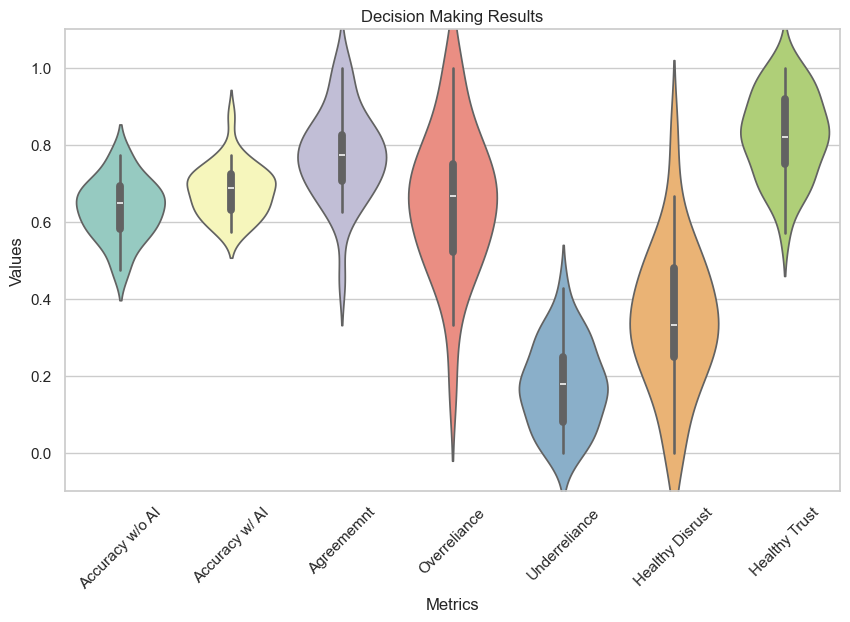

In [704]:
tick_labels = ['Accuracy w/o AI', 'Accuracy w/ AI', 'Agreememnt', 'Overreliance', 'Underreliance',  'Healthy Disrust', 'Healthy Trust']
plot_cols = ['accuracy1', 'accuracy2', 'reliance2', 'overreliance2', 'underreliance2', 'healthy_distrust2', 'healthy_trust2']
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df[plot_cols], inner='box', palette='Set3')  # Set inner=None to remove bars

df_tmp = df[['accuracy1', 'accuracy2']]
# for index, row in df_tmp.iterrows():
#   plt.plot(df_tmp.columns, row, marker='o', label=f'ID {index}')

plt.title('Decision Making Results')
plt.xlabel('Metrics')
plt.ylabel('Values')
ax.set_xticklabels(tick_labels)
plt.xticks(rotation = 45)

plt.ylim([-0.1, 1.1]);
# plt.legend()

/var/folders/cn/w2dpgz0941bcbfg3wgqzyr6c0000gn/T/ipykernel_30210/152045216.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels)


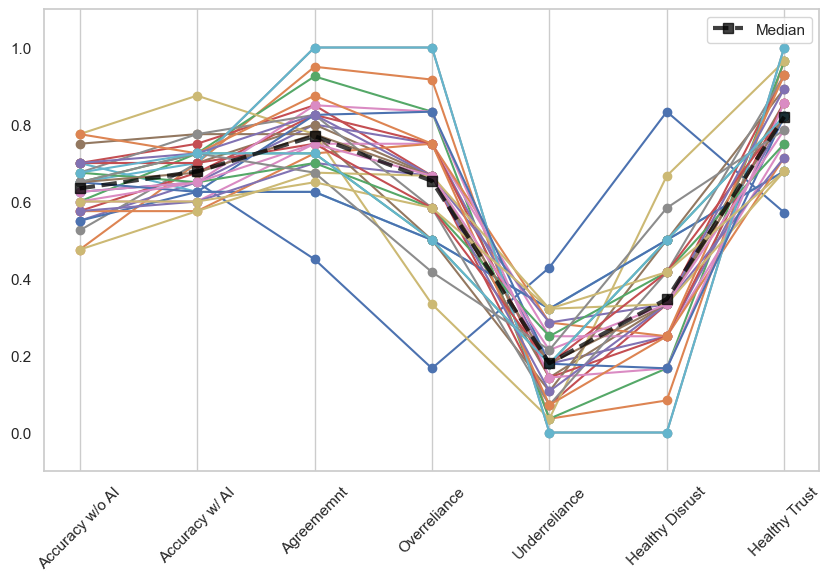

In [705]:
# Create a line plot for each row
plt.figure(figsize=(10, 6))  # Set the figure size


# Plot each row's values as a separate line
for index, row in df[plot_cols].iterrows():
  plt.plot(df[plot_cols].columns, row, marker='o')

plt.plot(df[plot_cols].columns, means[plot_cols], marker='s', label=f'Median', linestyle='--', linewidth=3, color='black', alpha=0.75, markersize=7)

ax = plt.gca()
ax.set_xticklabels(tick_labels)
plt.xticks(rotation = 45)
ax.grid(False, axis='y')

plt.ylim([-0.1, 1.1])
plt.legend()

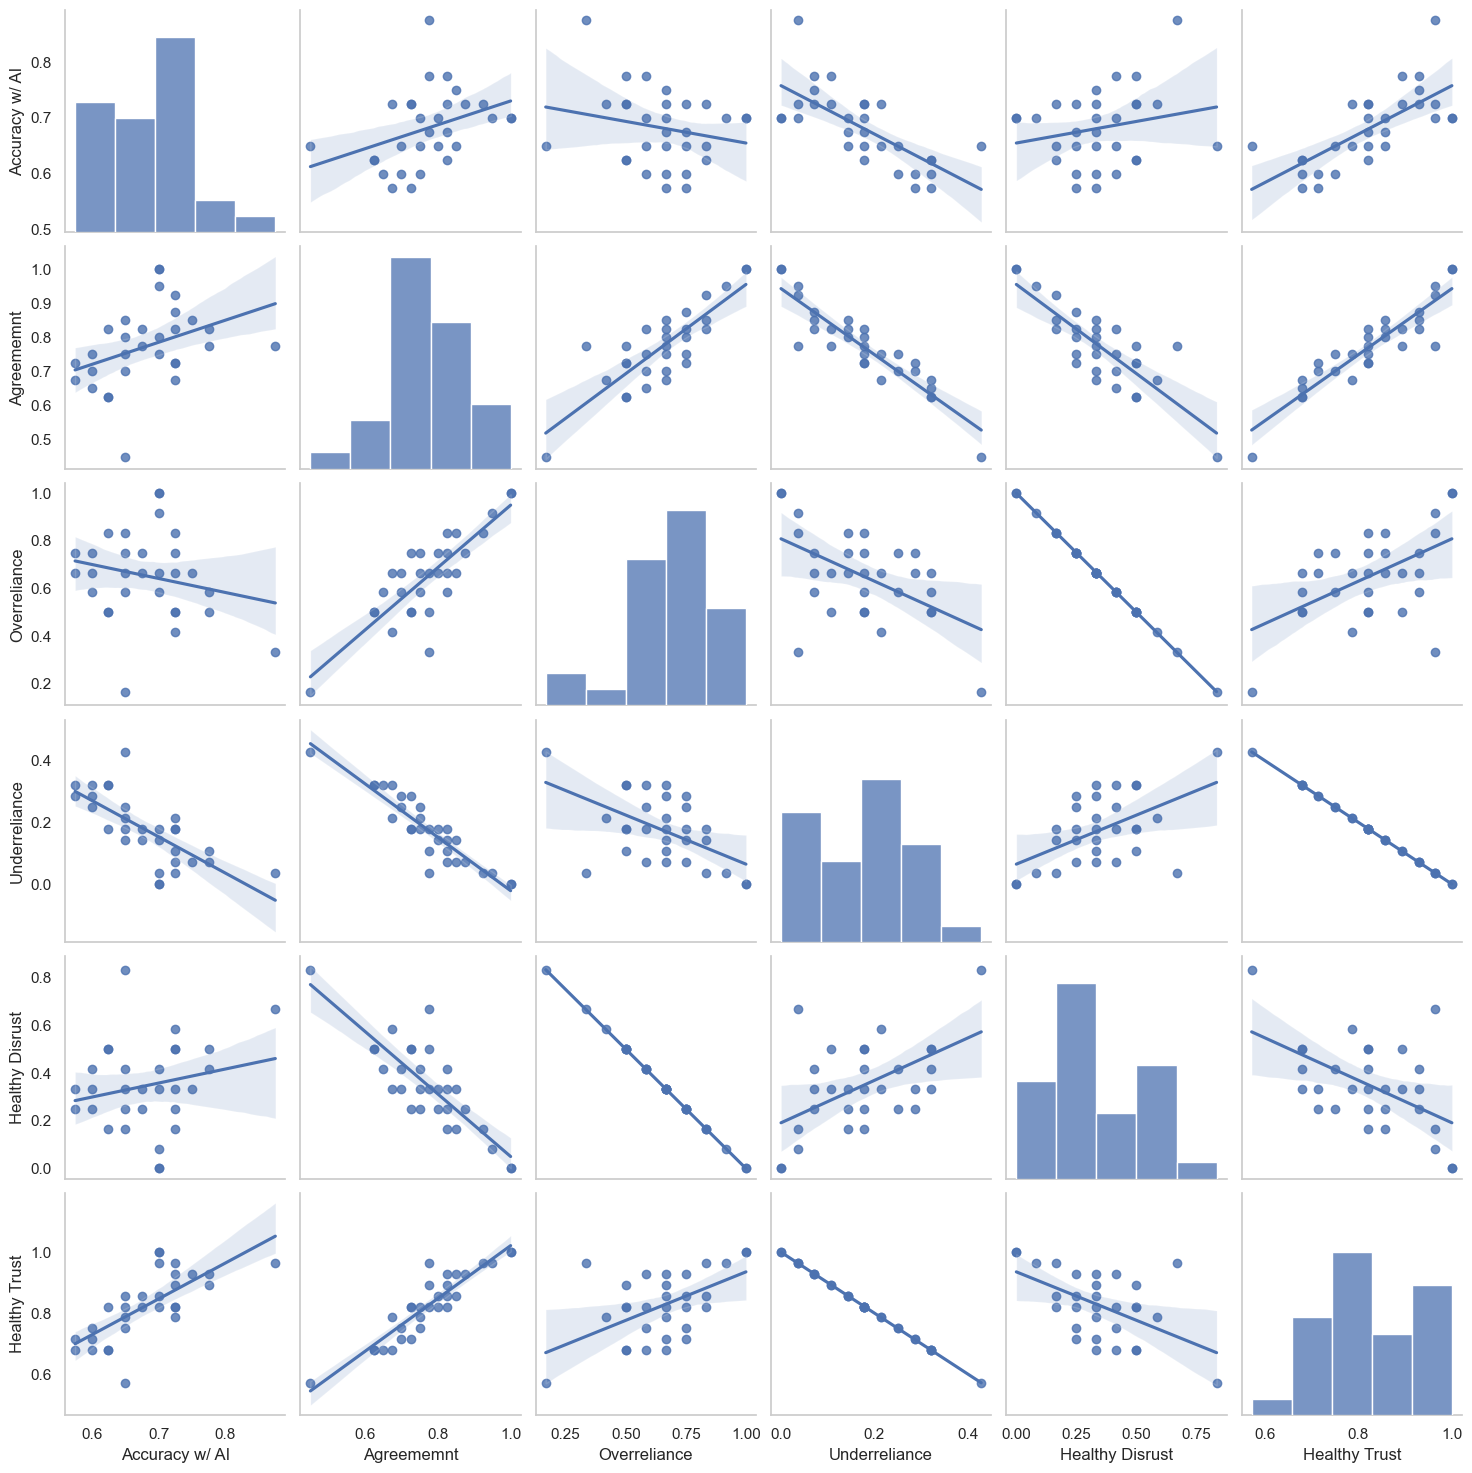

In [706]:
labels = tick_labels[1:]
df_tmp = df.drop(columns=['accuracy0','accuracy1', 'dec_time0', 'dec_time1', 'dec_time2'])
axes = sns.pairplot(df_tmp, kind='reg', diag_kind='hist', diag_kws={'bins': 5})
# Disable grid for each axis in the pair plot
for ax in axes.axes.flat:
    ax.grid(False)

for i, ax_row in enumerate(axes.axes):
  for j, ax in enumerate(ax_row):
    if j == 0:
      ax.set_ylabel(labels[i])
    if i == len(axes.axes) - 1:
      ax.set_xlabel(labels[j])


In [615]:
df.describe()

accuracy0  accuracy1  accuracy2  reliance2  overreliance2  \
count  26.000000  26.000000  26.000000  26.000000      26.000000   
mean    0.819231   0.624038   0.663462   0.721154       0.592949   
std     0.187124   0.095258   0.084330   0.165936       0.249808   
min     0.300000   0.400000   0.475000   0.450000       0.250000   
25%     0.762500   0.575000   0.631250   0.581250       0.354167   
50%     0.850000   0.625000   0.662500   0.725000       0.583333   
75%     0.950000   0.650000   0.700000   0.818750       0.750000   
max     1.000000   0.900000   0.850000   1.000000       1.000000   

       underreliance2  healthy_distrust2  healthy_trust2     dec_time0  \
count       26.000000          26.000000       26.000000     26.000000   
mean         0.223901           0.407051        0.776099  14415.772368   
std          0.153715           0.249808        0.153715  12470.147045   
min          0.000000           0.000000        0.535714   3747.750000   
25%          0.107143           0.250000        0.651786   5910.275000   
50%          0.214286           0.416667        0.785714  10259.625000   
75%          0.348214           0.645833        0.892857  17741.325000   
max          0.464286           0.750000        1.000000  53086.000000   

          dec_time1     dec_time2  
count     26.000000     26.000000  
mean    6929.356772   5269.017247  
std     5162.904861   2673.830728  
min     2620.900000   2074.775000  
25%     3998.256250   3892.156731  
50%     5492.975000   4576.350000  
75%     7076.650000   6082.425000  
max    25188.871795  13990.150000

In [707]:
for id1, df1 in dfs_1.items():
    df1['userid'] = id1

for id2, df2 in dfs_2.items():
    df2['userid'] = id2

df_noai = pd.concat(dfs_1.values())
df_ai = pd.concat(dfs_2.values())

In [708]:
get_results(df_ai, stage=2)

(0.6816666666666666,
 0.7733333333333333,
 0.6527777777777778,
 0.175,
 0.22666666666666666,
 0.3472222222222222,
 0.825,
 7166.1483333333335)

In [709]:
agree_cond = df_ai['pred'] == df_ai['select']
disagree_cond = df_ai['pred'] != df_ai['select']

correct_preds = (df_ai['pred'] == df_ai['true'])
incorrect_preds = (df_ai['pred'] != df_ai['true'])

or_cond = incorrect_preds & agree_cond
ur_cond = correct_preds & disagree_cond

ht_cond = agree_cond & correct_preds
hd_cond = disagree_cond & incorrect_preds

ht_cond.astype(int).sum(), hd_cond.astype(int).sum(), or_cond.astype(int).sum(), ur_cond.astype(int).sum()

(693, 125, 235, 147)

In [710]:
df_or = df_ai[or_cond]['id'].value_counts().reset_index()
df_ur = df_ai[ur_cond]['id'].value_counts().reset_index()
df_hd = df_ai[hd_cond]['id'].value_counts().reset_index()
df_ht = df_ai[ht_cond]['id'].value_counts().reset_index()

In [711]:
gdrive = Path('/Users/djohnson/Library/CloudStorage/GoogleDrive-fortjay81@gmail.com/My Drive')
samples_path = gdrive / 'hcxai/blockies/oc_degeneration_v3_2class/highvar_input/pytorch_model'

xai_samples_csv = samples_path / '2025-01-16/xai_samples/xai_samples_df.csv'
df_xai_samples = pd.read_csv(xai_samples_csv )

In [712]:
# (or setup own data location if prefered)
data_dir_sickones = utils.download_file(url="https://uni-bielefeld.sciebo.de/s/AIJLvXMwP0ngEiW/download",
                               file_name="two4two_datasets.tar.gz",
                               cache_dir= '../data',
                               extract=False,
                               force_download=False,
                               archive_folder='two4two_datasets')
data_dir_sickones

File already exists at: ../data/two4two_datasets.tar.gz
File already extracted to: ../data/two4two_datasets


PosixPath('../data/two4two_datasets')

In [713]:
eval_data_dir = data_dir_sickones.with_suffix('').with_suffix('') / 'sick_ones_bendbias_v3_2class_variation/'
(eval_data_dir / 'test').exists()

True

In [714]:
def get_image(id):
  f_path = eval_data_dir / 'test' / df_xai_samples.loc[df_xai_samples.id == id, 'filename'].values[0]
  ill_chars = df_xai_samples.loc[df_xai_samples.id == id, 'ill_chars'].values[0]
  image = np.array(Image.open(f_path).convert('RGB')) * 1. / 255
  return image, ill_chars

In [715]:
df_or

id  count
0   c766cabc-30e5-4d85-80da-2927a51cd819     27
1   1d690c7b-c566-482d-8940-2386ee5d5364     26
2   3c053c4f-9e28-406f-b9c2-924377d30ccb     25
3   27ce8b38-01a2-4787-84e3-6119acf9d2c5     24
4   e60423f6-8191-4cdd-84e4-cc4895cc925f     22
5   0ec401e3-48a9-44e3-807c-e950d9f84760     21
6   236f256c-4274-44dc-b0b8-442a8bdfef5b     21
7   66651fd4-ef75-4ce3-a1d2-255281116423     18
8   22a11fec-8675-45c9-a24b-9a909bf9ea1d     18
9   ef69b60e-ec3b-4e3b-ad65-14787b2c76af     14
10  1fb1acfc-03c9-4a6e-b57a-e930051d04ca     10
11  c5907dc1-1804-4258-9d93-3bb2d0702ca0      9

In [716]:
most_or_images = df_or[df_or['count'] > 3]
imgs = {s.id: get_image(s.id) for _, s in most_or_images.iterrows()}
len(imgs)

12

['med_sphere_diff', 'mutation_color', 'high_bend']
['mutation_mainbones', 'high_sphere_diff', 'high_bend', 'mutation_color']
['med_bend', 'med_sphere_diff']
['high_bend', 'stretchy', 'mutation_color']
['high_bend', 'mutation_mainbones', 'med_sphere_diff']
['mutation_color', 'med_sphere_diff', 'stretchy']
[]
['high_bend', 'high_sphere_diff']
['stretchy', 'high_sphere_diff', 'high_bend', 'mutation_color']
['high_sphere_diff', 'med_bend']


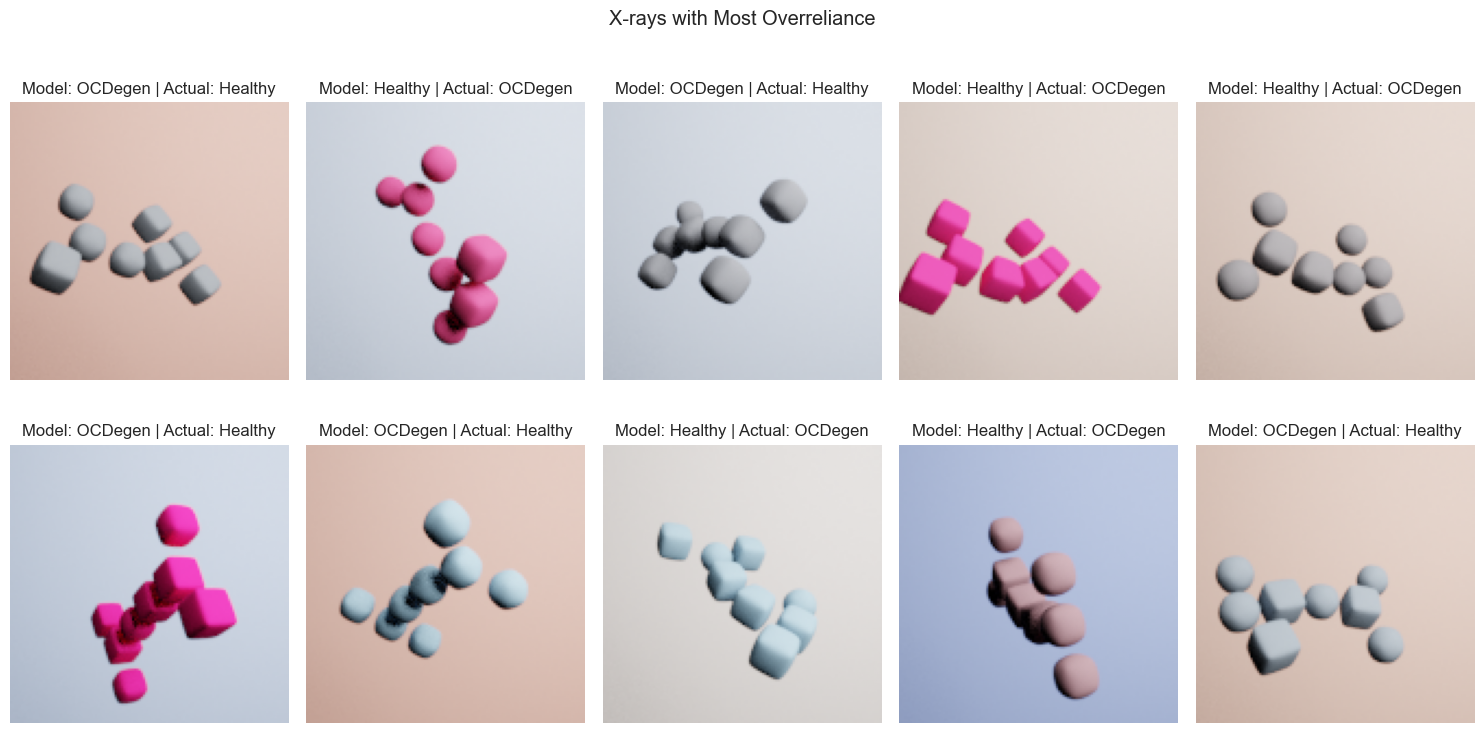

In [717]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

for ax, (id, img) in zip(axes.flatten(), imgs.items()):
    img, ill_chars = img
    print(ill_chars)
    ax.imshow(img)
    # user = df_xai_samples[df_xai_samples['id'] == id]['select']
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
plt.suptitle('X-rays with Most Overreliance')
plt.tight_layout()

In [743]:
df_ai_sorted = df_ai.sort_values(by=['id', 'userid'], ignore_index=True)
df_noai_sorted = df_noai.sort_values(by=['id', 'userid'], ignore_index=True)

flipped_df = df_ai_sorted[df_ai_sorted['select'] != df_noai_sorted['select']]

inc_cond = flipped_df['pred'] != flipped_df['true']
agg_cond = flipped_df['pred'] == flipped_df['select']
corr_cond = flipped_df['pred'] == flipped_df['true']
or_cond_f = inc_cond & agg_cond
ht_cond_f = agg_cond & corr_cond

# flipped_df[or_cond_f]

In [741]:
flipped_ids_or_df = flipped_df[or_cond_f]['id'].value_counts().reset_index()

['high_bend', 'stretchy', 'mutation_color']
['high_bend', 'mutation_mainbones', 'med_sphere_diff']
['mutation_mainbones', 'high_sphere_diff', 'high_bend', 'mutation_color']
['mutation_color', 'med_sphere_diff', 'stretchy']
['high_bend', 'high_sphere_diff']
['stretchy', 'high_sphere_diff', 'high_bend', 'mutation_color']
[]
['mutation_mainbones', 'high_bend', 'med_sphere_diff']


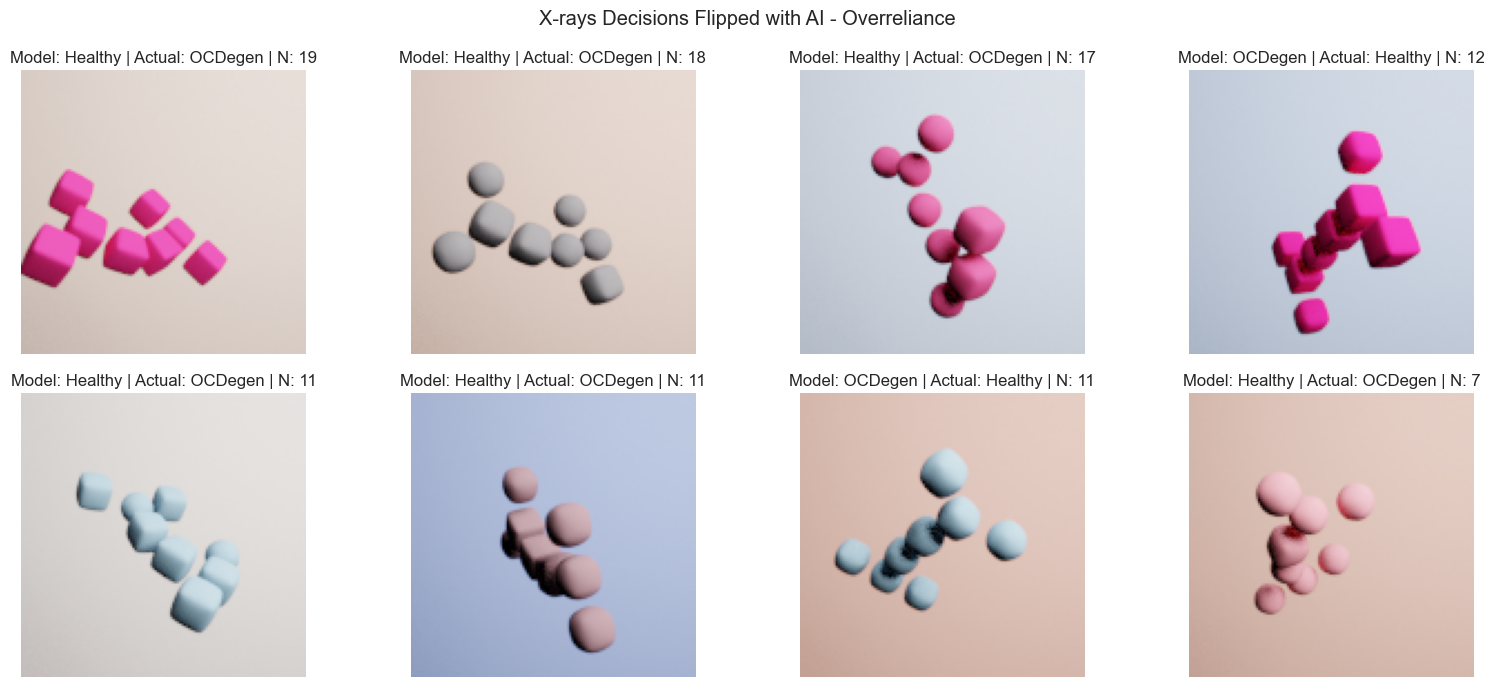

In [754]:
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 7))

for ax, (idx, row) in zip(axes.flatten(), flipped_ids_or_df.iterrows()):
    id = row['id']
    img, ill_chars = get_image(id)
    n = row['count']
    print(ill_chars)
    ax.imshow(img)
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual} | N: {n}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays Decisions Flipped with AI - Overreliance')
plt.tight_layout()

In [756]:
flipped_ids_ht_df = flipped_df[ht_cond_f]['id'].value_counts().reset_index()

['high_bend', 'mutation_color', 'med_sphere_diff']
['mutation_color', 'med_sphere_diff', 'high_bend']
['med_sphere_diff', 'high_bend']
['mutation_color', 'high_sphere_diff']
['high_sphere_diff', 'stretchy', 'med_bend']
['high_sphere_diff', 'stretchy', 'med_bend']
['high_bend', 'high_sphere_diff', 'mutation_color']
['mutation_mainbones', 'stretchy', 'med_sphere_diff']


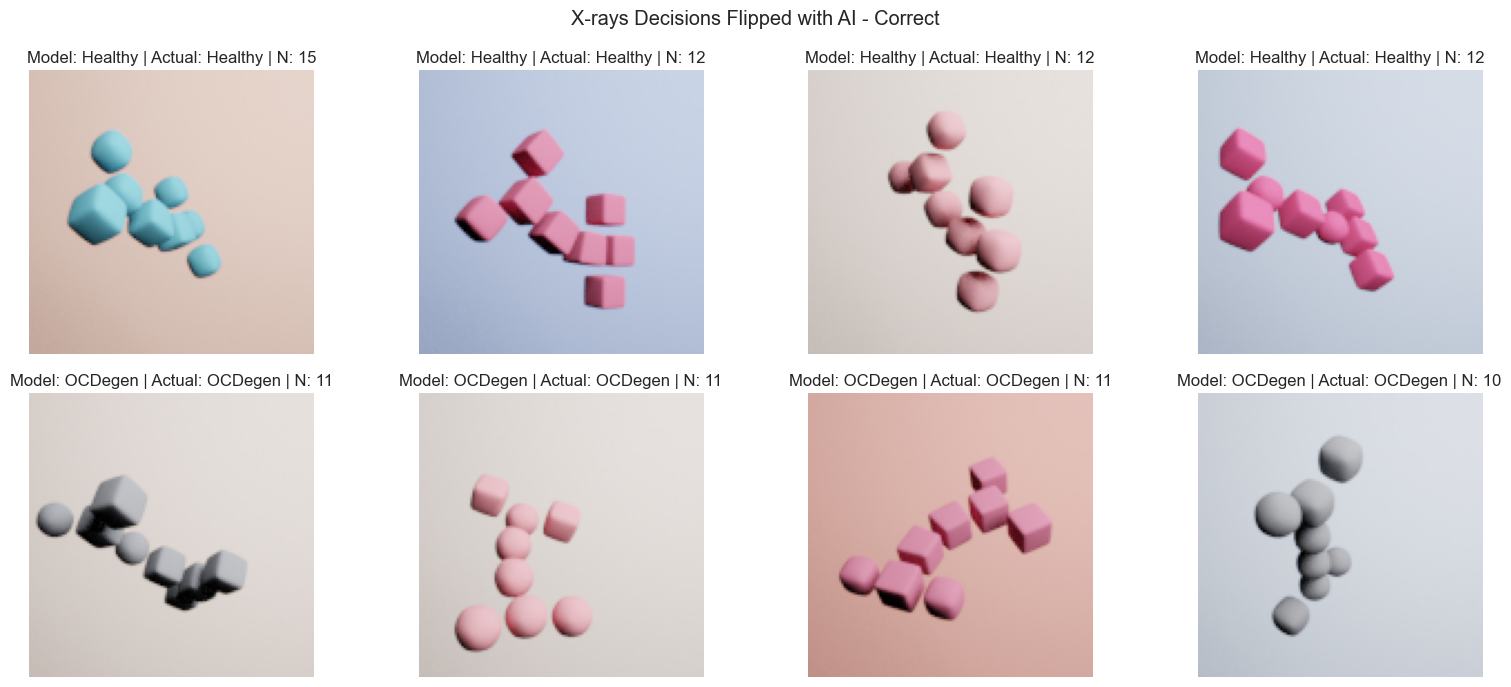

In [759]:
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 7))

for ax, (idx, row) in zip(axes.flatten(), flipped_ids_ht_df.iterrows()):
    id = row['id']
    img, ill_chars = get_image(id)
    n = row['count']
    print(ill_chars)
    ax.imshow(img)
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual} | N: {n}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays Decisions Flipped with AI - Correct')
plt.tight_layout()

['med_sphere_diff', 'mutation_mainbones', 'med_bend']
['stretchy', 'mutation_mainbones', 'med_sphere_diff']
['high_bend', 'mutation_color', 'med_sphere_diff']
['med_sphere_diff', 'high_bend']
['stretchy', 'high_sphere_diff', 'mutation_color']
['med_sphere_diff', 'mutation_mainbones']
['high_sphere_diff', 'stretchy', 'med_bend']
['high_bend', 'high_sphere_diff', 'mutation_color']


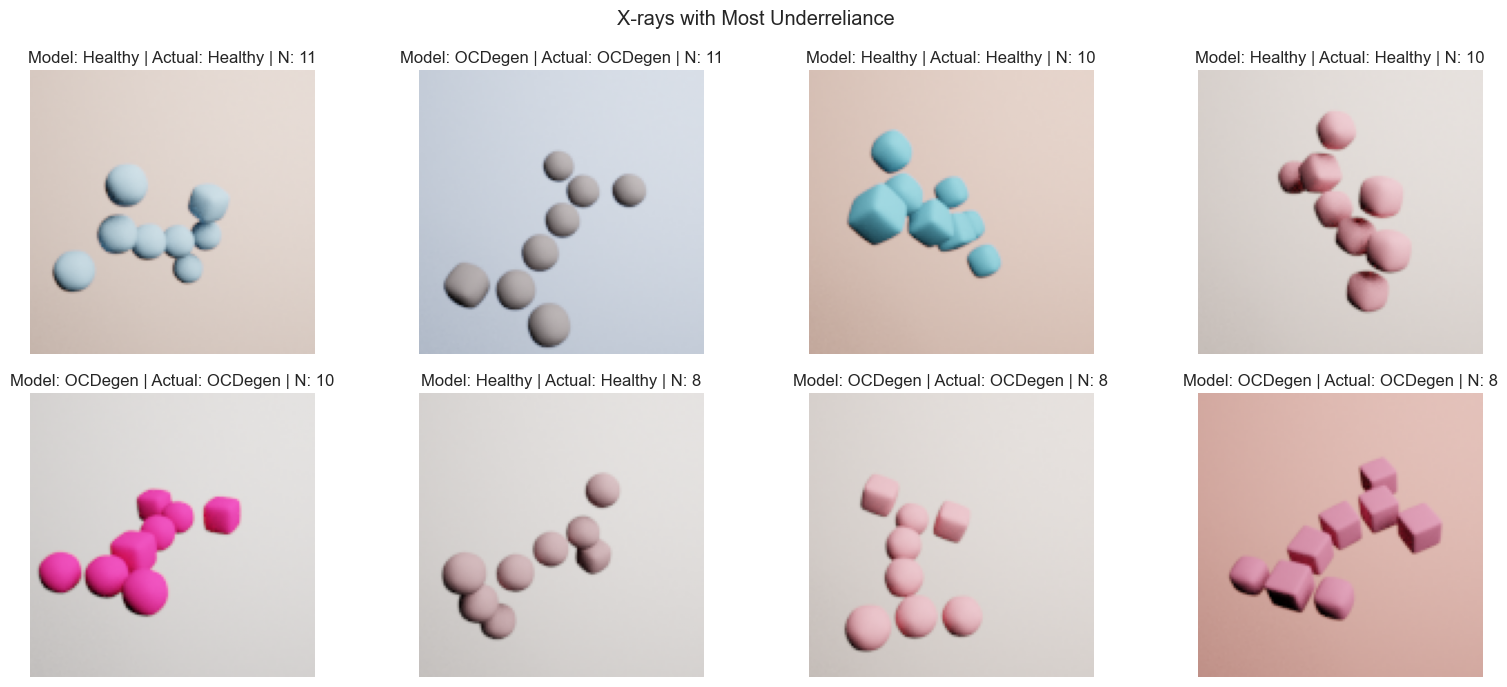

In [761]:
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 7))

for ax, (idx, row) in zip(axes.flatten(), df_ur.iterrows()):
    id = row['id']
    img, ill_chars = get_image(id)
    n = row['count']
    print(ill_chars)
    ax.imshow(img)
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual} | N: {n}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays with Most Underreliance')
plt.tight_layout()

In [725]:
df_hd

id  count
0   c5907dc1-1804-4258-9d93-3bb2d0702ca0     21
1   1fb1acfc-03c9-4a6e-b57a-e930051d04ca     20
2   ef69b60e-ec3b-4e3b-ad65-14787b2c76af     16
3   66651fd4-ef75-4ce3-a1d2-255281116423     12
4   22a11fec-8675-45c9-a24b-9a909bf9ea1d     12
5   0ec401e3-48a9-44e3-807c-e950d9f84760      9
6   236f256c-4274-44dc-b0b8-442a8bdfef5b      9
7   e60423f6-8191-4cdd-84e4-cc4895cc925f      8
8   27ce8b38-01a2-4787-84e3-6119acf9d2c5      6
9   3c053c4f-9e28-406f-b9c2-924377d30ccb      5
10  1d690c7b-c566-482d-8940-2386ee5d5364      4
11  c766cabc-30e5-4d85-80da-2927a51cd819      3

In [726]:
most_hd_images = df_hd[df_hd['count'] > 2]
hd_imgs = {s.id: get_image(s.id) for _, s in most_hd_images.iterrows()}
len(hd_imgs)

12

['mutation_color']
['mutation_mainbones', 'high_bend', 'med_sphere_diff']
['high_sphere_diff', 'med_bend']
['high_bend', 'high_sphere_diff']
['stretchy', 'high_sphere_diff', 'high_bend', 'mutation_color']
['mutation_color', 'med_sphere_diff', 'stretchy']
[]
['high_bend', 'mutation_mainbones', 'med_sphere_diff']


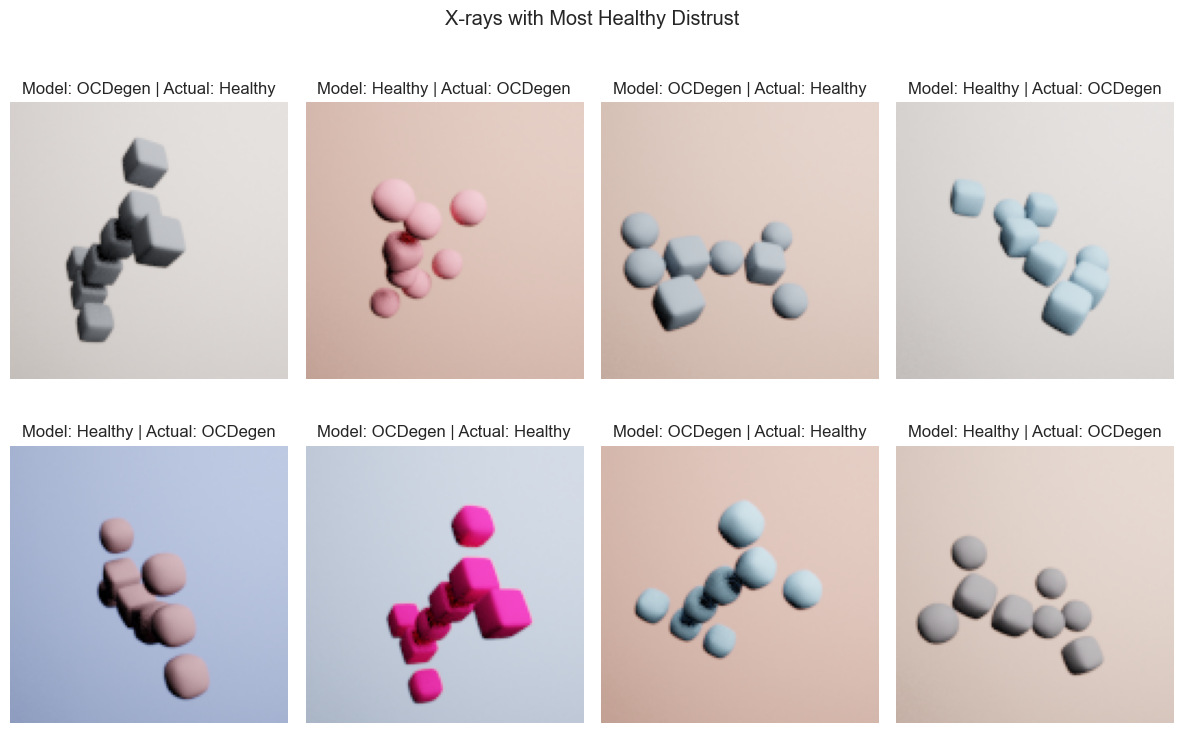

In [727]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8))

for ax, (id, img) in zip(axes.flatten(), hd_imgs.items()):
    img, ill_chars = img
    print(ill_chars)
    ax.imshow(img)
    # user = df_xai_samples[df_xai_samples['id'] == id]['select']
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays with Most Healthy Distrust')
plt.tight_layout()

In [728]:
df_ht.head(15)

id  count
0   9ea15ed1-2360-4090-94c0-c2e12adce048     30
1   976dae6d-b230-4907-a011-043c66af1845     30
2   c5c9f278-9329-41ac-b2f4-df0068815ff6     29
3   a3bff5d0-4186-461e-bbaa-c5d5d089ac8f     29
4   0a43a265-1afa-47a5-807e-402622e5b3c8     28
5   0575626d-1155-4f79-a8ed-151c82499cee     28
6   d9904323-8935-4005-ab74-a49b13154c0e     28
7   abc0790a-e02d-432e-9b1c-7af815cd99c0     27
8   0a6a8b66-04f9-443f-a92f-8da31418674a     27
9   be0f39a0-66bb-4340-8547-382602aa7ada     26
10  eac32a1b-c04e-4628-9377-70cfed19ffdc     26
11  2fdd906b-a9b2-4c4b-b66b-94ab1efb1f97     26
12  54d52a66-a1e2-438e-9f42-175cc76248fc     26
13  cd099c51-fa15-4681-bf2a-3684a8f7dfe7     25
14  811602c2-63d0-48e9-90fe-a0b77c027aca     25

In [729]:
most_ht_images = df_ht[df_ht['count'] > 9]
ht_imgs = {s.id: get_image(s.id) for _, s in most_ht_images.iterrows()}
len(ht_imgs)

28

['mutation_color']
[]
['stretchy', 'high_sphere_diff', 'med_bend']
['med_sphere_diff', 'mutation_color']
['mutation_color', 'med_sphere_diff', 'high_bend']
['stretchy']
['stretchy', 'high_bend', 'mutation_color']
['med_sphere_diff']
['med_sphere_diff', 'mutation_color', 'med_bend', 'stretchy']
['high_sphere_diff', 'high_bend', 'stretchy', 'mutation_color']


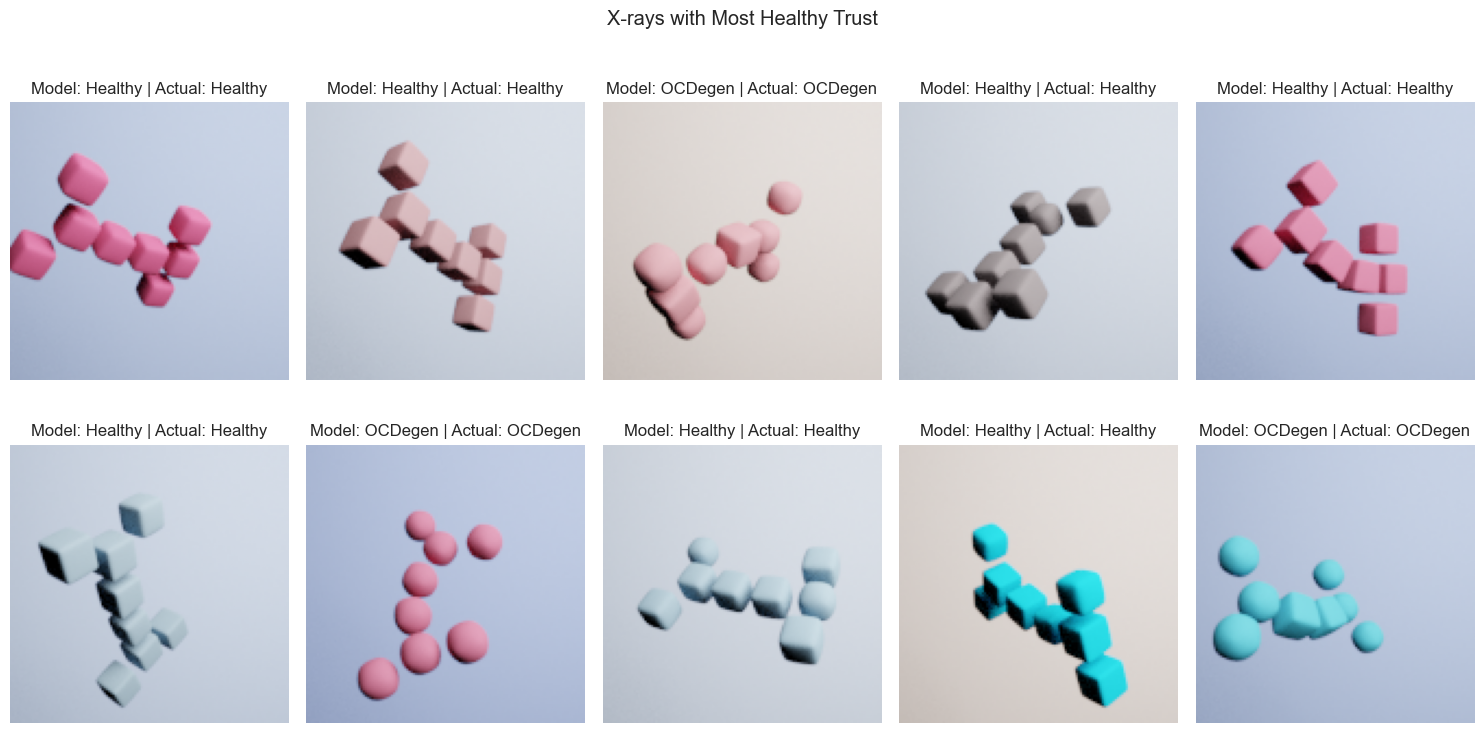

In [730]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

for ax, (id, img) in zip(axes.flatten(), ht_imgs.items()):
    img, ill_chars = img
    print(ill_chars)
    ax.imshow(img)
    # user = df_xai_samples[df_xai_samples['id'] == id]['select']
    model = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'pred'].values[0]]
    actual = CLASSES[df_xai_samples.loc[df_xai_samples['id'] == id, 'ill'].values[0]]
    ax.set_title(f'Model: {model} | Actual: {actual}')
    ax.axis('off')
axes.flatten()[-1].axis('off')
plt.suptitle('X-rays with Most Healthy Trust')
plt.tight_layout()

In [731]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [732]:
def plot_cms(df_ai, df_noai, cond, name):

  if cond is None:
    cond = [True] * len(df_ai)

  ids, uids = df_ai[cond]['id'], df_ai[cond]['userid']
  rows = []
  for id, uid in zip(ids, uids):
    rows.append(df_noai[(df_noai['id']==id) & (df_noai['userid']==uid)])
  df_noai_cond = pd.concat(rows)

  print(f'No AI - Dropped {df_noai_cond["select"].isna().astype(int).sum()} NaN')
  df_noai_cond = df_noai_cond.dropna(subset=['select'])

  df_ai_cond = df_ai[cond]
  print(f'AI - Dropped {df_ai_cond["select"].isna().astype(int).sum()} NaN')
  df_ai_cond = df_ai_cond.dropna(subset=['select'])


  cm_noai = confusion_matrix(df_noai_cond['true'], df_noai_cond['select'])
  cm_ai = confusion_matrix(df_ai_cond['true'], df_ai_cond['select'])

  maxlim = max(cm_noai.max(), cm_ai.max())

  fig, axes = plt.subplots(2, 1, figsize=(6, 10))

  disp = ConfusionMatrixDisplay(cm_noai, display_labels=CLASSES)
  disp.plot(cmap='Blues', ax = axes[0], colorbar=False)
  axes[0].grid(False)
  axes[0].set_title('User Diagnoses - No AI')
  axes[0].set_xticklabels([])
  axes[0].set_xlabel("")
  axes[0].set_yticklabels(CLASSES, rotation=90,  ha='right', va='center')
  im = axes[0].images[0]
  im.set_clim(0, maxlim) 

  disp = ConfusionMatrixDisplay(cm_ai, display_labels=CLASSES)
  disp.plot(cmap='Blues', ax = axes[1], colorbar=False)
  axes[1].grid(False)
  axes[1].set_yticklabels(CLASSES, rotation=90, ha='right', va='center')
  axes[1].set_title('User Diagnoses - With AI')
  im = axes[1].images[0]
  im.set_clim(0, maxlim) 

  plt.suptitle(f'User Diagnoses - {name}')
  plt.tight_layout()

In [733]:
(145 + 144 + 36 + 9) /400

0.835

No AI - Dropped 1 NaN
AI - Dropped 0 NaN


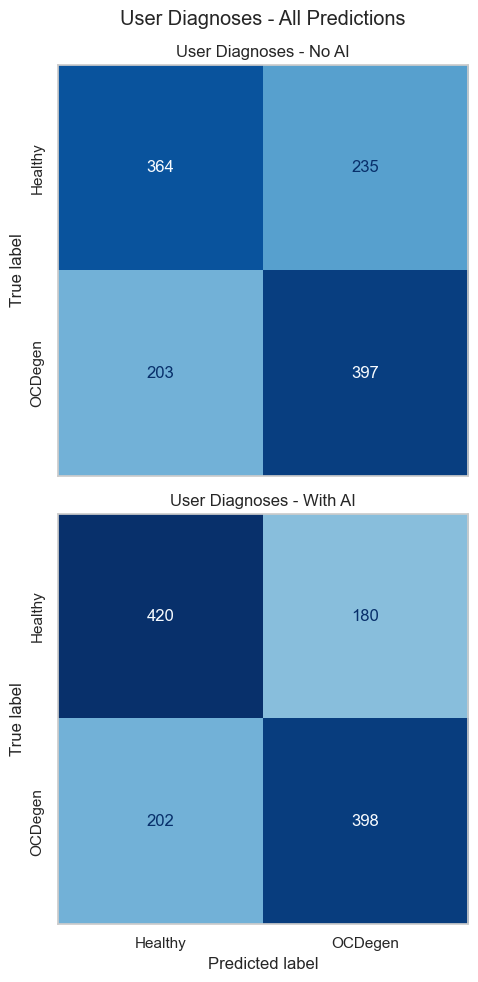

In [734]:
plot_cms(df_ai, df_noai, None, 'All Predictions')

No AI - Dropped 0 NaN
AI - Dropped 0 NaN


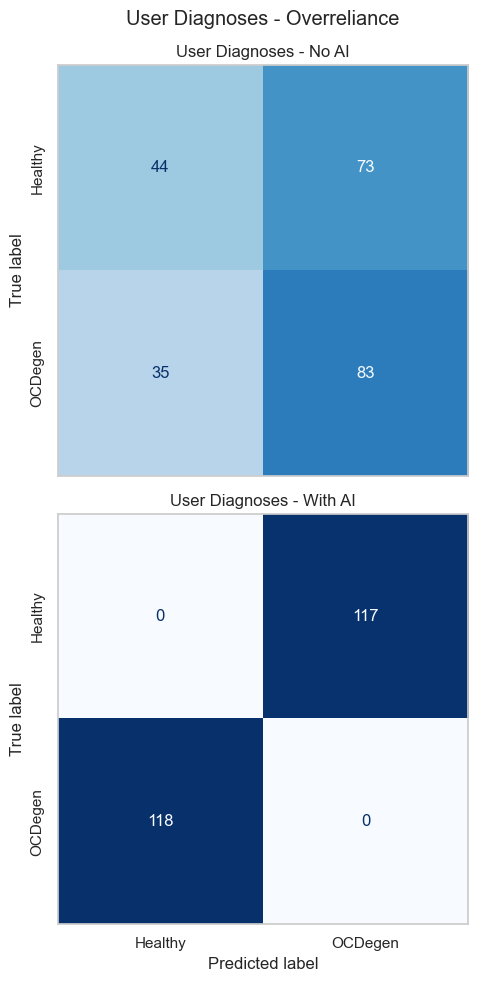

In [735]:
plot_cms(df_ai, df_noai, or_cond, 'Overreliance')

No AI - Dropped 1 NaN
AI - Dropped 0 NaN


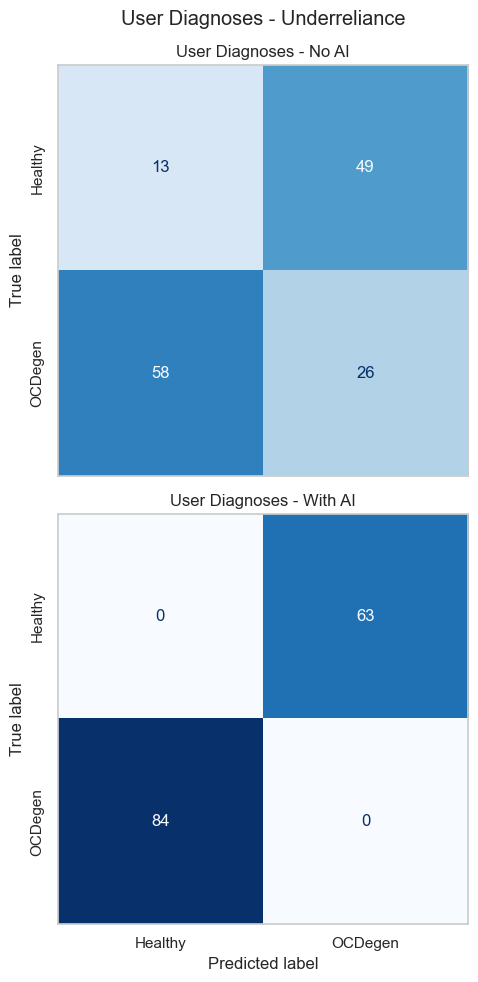

In [736]:
plot_cms(df_ai, df_noai, ur_cond, 'Underreliance')

No AI - Dropped 0 NaN
AI - Dropped 0 NaN


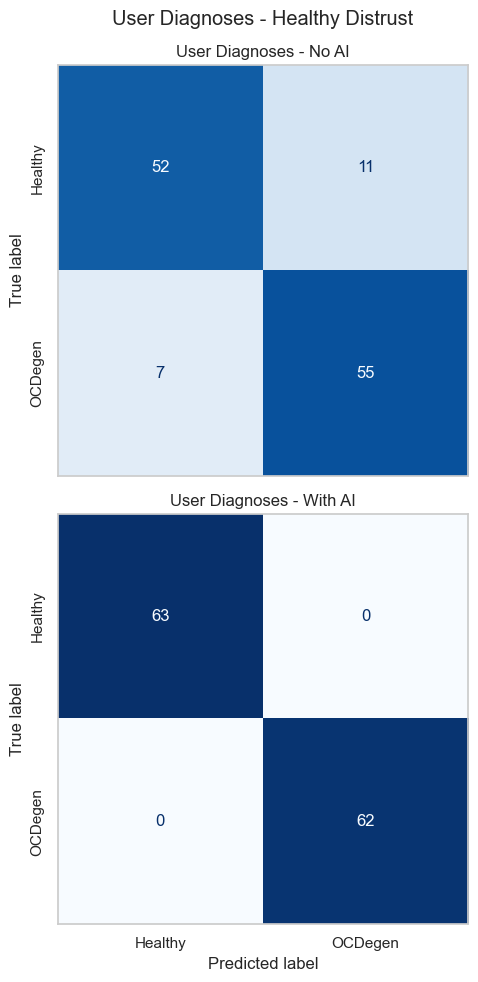

In [737]:
plot_cms(df_ai, df_noai, hd_cond, 'Healthy Distrust')

No AI - Dropped 0 NaN
AI - Dropped 0 NaN


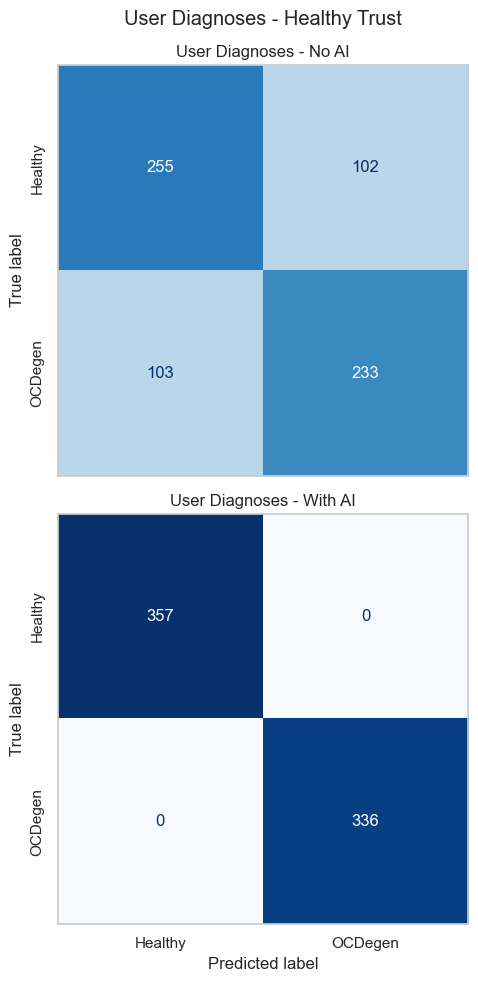

In [738]:
plot_cms(df_ai, df_noai, ht_cond, 'Healthy Trust')